# McKinney Chapter 11 - Time Series

## Introduction

Chapter 11 of Wes McKinney's [*Python for Data Analysis*](https://wesmckinney.com/pages/book.html) discusses time series and panel data, which is where pandas ***shines***.
We will use these time series and panel tools every day for the rest of the course.

We will focus on:

1. Slicing a data frame or series by date or date range
1. Using `.shift()` to create leads and lags of variables
1. Using `.resample()` to change the frequency of variables
1. Using `.rolling()` to aggregate data over rolling windows

***Note:*** Indented block quotes are from McKinney, and section numbers differ from McKinney because we will not discuss every topic.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
%config InlineBackend.figure_format = 'retina'
%precision 4
pd.options.display.float_format = '{:.4f}'.format

In [4]:
import requests_cache
session = requests_cache.CachedSession(expire_after='1D')
import yfinance as yf
import pandas_datareader as pdr

McKinney provides an excellent introduction to the concept of time series and panel data:

> Time series data is an important form of structured data in many different fields, such
as finance, economics, ecology, neuroscience, and physics. Anything that is observed
or measured at many points in time forms a time series. Many time series are fixed
frequency, which is to say that data points occur at regular intervals according to some
rule, such as every 15 seconds, every 5 minutes, or once per month. Time series can
also be irregular without a fixed unit of time or offset between units. How you mark
and refer to time series data depends on the application, and you may have one of the
following:
> - Timestamps, specific instants in time
> - Fixed periods, such as the month January 2007 or the full year 2010
> - Intervals of time, indicated by a start and end timestamp. Periods can be thought
of as special cases of intervals
> - Experiment or elapsed time; each timestamp is a measure of time relative to a
particular start time (e.g., the diameter of a cookie baking each second since
being placed in the oven)
>
>In this chapter, I am mainly concerned with time series in the first three categories,
though many of the techniques can be applied to experimental time series where the
index may be an integer or floating-point number indicating elapsed time from the
start of the experiment. The simplest and most widely used kind of time series are
those indexed by timestamp.
323
>
> pandas provides many built-in time series tools and data algorithms. You can effi‐
ciently work with very large time series and easily slice and dice, aggregate, and
resample irregular- and fixed-frequency time series. Some of these tools are especially
useful for financial and economics applications, but you could certainly use them to
analyze server log data, too.

## Time Series Basics

Let us create a time series to play with.

In [5]:
from datetime import datetime
dates = [
    datetime(2011, 1, 2), 
    datetime(2011, 1, 5),
    datetime(2011, 1, 7), 
    datetime(2011, 1, 8),
    datetime(2011, 1, 10), 
    datetime(2011, 1, 12)
]
np.random.seed(42)
ts = pd.Series(np.random.randn(6), index=dates)

In [6]:
ts

2011-01-02    0.4967
2011-01-05   -0.1383
2011-01-07    0.6477
2011-01-08    1.5230
2011-01-10   -0.2342
2011-01-12   -0.2341
dtype: float64

Note that pandas converts the `datetime` objects to a pandas `DatetimeIndex` object and a single index value is a `Timestamp` object.

In [7]:
ts.index

DatetimeIndex(['2011-01-02', '2011-01-05', '2011-01-07', '2011-01-08',
               '2011-01-10', '2011-01-12'],
              dtype='datetime64[ns]', freq=None)

In [8]:
ts.index[0]

Timestamp('2011-01-02 00:00:00')

Recall that arithmetic operations between pandas objects automatically align on indexes.

In [9]:
ts[::2]

2011-01-02    0.4967
2011-01-07    0.6477
2011-01-10   -0.2342
dtype: float64

In [10]:
ts + ts[::2]

2011-01-02    0.9934
2011-01-05       NaN
2011-01-07    1.2954
2011-01-08       NaN
2011-01-10   -0.4683
2011-01-12       NaN
dtype: float64

### Indexing, Selection, Subsetting

We can use date and time labels to select data.

In [11]:
stamp = ts.index[2]

In [12]:
stamp

Timestamp('2011-01-07 00:00:00')

In [13]:
ts[stamp]

0.6477

pandas uses unambiguous date strings to select data.

In [14]:
ts['1/10/2011'] # M/D/YYYY

-0.2342

In [15]:
ts['20110110'] # YYYYMMDD

-0.2342

In [16]:
ts['2011-01-10'] # YYYY-MM-DD

-0.2342

In [17]:
ts['10-Jan-2011'] # D-Mon-YYYY

-0.2342

In [18]:
ts['Jan-10-2011'] # Mon-D-YYYY

-0.2342

But do not use U.K.-style dates.

In [19]:
# ts['10/1/2011'] # D/M/YYYY

Here is a longer time series for longer slices.

In [20]:
np.random.seed(42)
longer_ts = pd.Series(np.random.randn(1000), index=pd.date_range('1/1/2000', periods=1000))

In [21]:
longer_ts

2000-01-01    0.4967
2000-01-02   -0.1383
2000-01-03    0.6477
2000-01-04    1.5230
2000-01-05   -0.2342
               ...  
2002-09-22   -0.2811
2002-09-23    1.7977
2002-09-24    0.6408
2002-09-25   -0.5712
2002-09-26    0.5726
Freq: D, Length: 1000, dtype: float64

We can pass a year-month to slice all of the observations in May of 2001.

In [22]:
longer_ts['2001-05']

2001-05-01   -0.6466
2001-05-02   -1.0815
2001-05-03    1.6871
2001-05-04    0.8816
2001-05-05   -0.0080
2001-05-06    1.4799
2001-05-07    0.0774
2001-05-08   -0.8613
2001-05-09    1.5231
2001-05-10    0.5389
2001-05-11   -1.0372
2001-05-12   -0.1903
2001-05-13   -0.8756
2001-05-14   -1.3828
2001-05-15    0.9262
2001-05-16    1.9094
2001-05-17   -1.3986
2001-05-18    0.5630
2001-05-19   -0.6506
2001-05-20   -0.4871
2001-05-21   -0.5924
2001-05-22   -0.8640
2001-05-23    0.0485
2001-05-24   -0.8310
2001-05-25    0.2705
2001-05-26   -0.0502
2001-05-27   -0.2389
2001-05-28   -0.9076
2001-05-29   -0.5768
2001-05-30    0.7554
2001-05-31    0.5009
Freq: D, dtype: float64

We can also pass a year to slice all observations in 2001.

In [23]:
longer_ts['2001']

2001-01-01    0.2241
2001-01-02    0.0126
2001-01-03    0.0977
2001-01-04   -0.7730
2001-01-05    0.0245
               ...  
2001-12-27    0.0184
2001-12-28    0.3476
2001-12-29   -0.5398
2001-12-30   -0.7783
2001-12-31    0.1958
Freq: D, Length: 365, dtype: float64

If we sort our data chronologically, we can also slice with a range of date strings.

In [24]:
ts['1/6/2011':'1/10/2011']

2011-01-07    0.6477
2011-01-08    1.5230
2011-01-10   -0.2342
dtype: float64

To use date slices, our data should be sorted by the date index, as above.
The following code works as though our data were sorted, but raises a warning that it will not work in future versions.

In [25]:
ts2 = ts.sort_values()

In [26]:
ts2

2011-01-10   -0.2342
2011-01-12   -0.2341
2011-01-05   -0.1383
2011-01-02    0.4967
2011-01-07    0.6477
2011-01-08    1.5230
dtype: float64

The following behavior is "deprecated", meaning it will eventually go away and we should not rely up on it.

In [27]:
ts2['1/6/2011':'1/11/2011']

C:\Users\r.herron\AppData\Local\Temp\ipykernel_16560\1099700163.py:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  ts2['1/6/2011':'1/11/2011']


2011-01-10   -0.2342
2011-01-07    0.6477
2011-01-08    1.5230
dtype: float64

In [28]:
ts2.sort_index()['1/6/2011':'1/11/2011']

2011-01-07    0.6477
2011-01-08    1.5230
2011-01-10   -0.2342
dtype: float64

***To be clear, a range of date strings is inclusive on both ends.***

In [29]:
longer_ts['1/6/2001':'1/11/2001']

2001-01-06    0.4980
2001-01-07    1.4511
2001-01-08    0.9593
2001-01-09    2.1532
2001-01-10   -0.7673
2001-01-11    0.8723
Freq: D, dtype: float64

***Recall, if we modify a slice, we modify the original series or dataframe.***

> Remember that slicing in this manner produces views on the source time series like slicing NumPy arrays. This means that no data is copied and modifications on the slice will be reflected in the original data.

### Time Series with Duplicate Indices

Most data in this course will be well-formed with one observation per datetime for series or one observation per individual per datetime for dataframes.
However, you may later receive poorly-formed data with duplicate observations.
The toy data in series `dup_ts` has three observations on February 2nd.

In [30]:
dates = pd.DatetimeIndex(['1/1/2000', '1/2/2000', '1/2/2000', '1/2/2000', '1/3/2000'])
dup_ts = pd.Series(np.arange(5), index=dates)

In [31]:
dup_ts

2000-01-01    0
2000-01-02    1
2000-01-02    2
2000-01-02    3
2000-01-03    4
dtype: int32

The `.is_unique` property tells us if an index is unique.

In [32]:
dup_ts.index.is_unique

False

In [33]:
dup_ts['1/3/2000']  # not duplicated

4

In [34]:
dup_ts['1/2/2000']  # duplicated

2000-01-02    1
2000-01-02    2
2000-01-02    3
dtype: int32

The solution to duplicate data depends on the context.
For example, we may want the mean of all observations on a given date.
The `.groupby()`  method can help us here.

In [35]:
grouped = dup_ts.groupby(level=0)

In [36]:
grouped.mean()

2000-01-01   0.0000
2000-01-02   2.0000
2000-01-03   4.0000
dtype: float64

In [37]:
grouped.last()

2000-01-01    0
2000-01-02    3
2000-01-03    4
dtype: int32

Or we may want the number of observations on each date.

In [38]:
grouped.count()

2000-01-01    1
2000-01-02    3
2000-01-03    1
dtype: int64

## Date Ranges, Frequencies, and Shifting

> Generic time series in pandas are assumed to be irregular; that is, they have no fixed frequency. For many applications this is sufficient. However, it’s often desirable to work relative to a fixed frequency, such as daily, monthly, or every 15 minutes, even if that means introducing missing values into a time series. Fortunately pandas has a full suite of standard time series frequencies and tools for resampling, inferring frequencies, and generating fixed-frequency date ranges.

### Generating Date Ranges

pandas makes it easy to generate date ranges.
If we pass a start and end date, `pandas.date_range()` assumes daily frequency:

> freq : str or DateOffset, default 'D'

In [39]:
index = pd.date_range('2012-04-01', '2012-06-01')

In [40]:
index

DatetimeIndex(['2012-04-01', '2012-04-02', '2012-04-03', '2012-04-04',
               '2012-04-05', '2012-04-06', '2012-04-07', '2012-04-08',
               '2012-04-09', '2012-04-10', '2012-04-11', '2012-04-12',
               '2012-04-13', '2012-04-14', '2012-04-15', '2012-04-16',
               '2012-04-17', '2012-04-18', '2012-04-19', '2012-04-20',
               '2012-04-21', '2012-04-22', '2012-04-23', '2012-04-24',
               '2012-04-25', '2012-04-26', '2012-04-27', '2012-04-28',
               '2012-04-29', '2012-04-30', '2012-05-01', '2012-05-02',
               '2012-05-03', '2012-05-04', '2012-05-05', '2012-05-06',
               '2012-05-07', '2012-05-08', '2012-05-09', '2012-05-10',
               '2012-05-11', '2012-05-12', '2012-05-13', '2012-05-14',
               '2012-05-15', '2012-05-16', '2012-05-17', '2012-05-18',
               '2012-05-19', '2012-05-20', '2012-05-21', '2012-05-22',
               '2012-05-23', '2012-05-24', '2012-05-25', '2012-05-26',
      

If we specify only a start or end date, we must specify the number of periods.

In [41]:
pd.date_range(start='2012-04-01', periods=20)

DatetimeIndex(['2012-04-01', '2012-04-02', '2012-04-03', '2012-04-04',
               '2012-04-05', '2012-04-06', '2012-04-07', '2012-04-08',
               '2012-04-09', '2012-04-10', '2012-04-11', '2012-04-12',
               '2012-04-13', '2012-04-14', '2012-04-15', '2012-04-16',
               '2012-04-17', '2012-04-18', '2012-04-19', '2012-04-20'],
              dtype='datetime64[ns]', freq='D')

In [42]:
pd.date_range(end='2012-06-01', periods=20)

DatetimeIndex(['2012-05-13', '2012-05-14', '2012-05-15', '2012-05-16',
               '2012-05-17', '2012-05-18', '2012-05-19', '2012-05-20',
               '2012-05-21', '2012-05-22', '2012-05-23', '2012-05-24',
               '2012-05-25', '2012-05-26', '2012-05-27', '2012-05-28',
               '2012-05-29', '2012-05-30', '2012-05-31', '2012-06-01'],
              dtype='datetime64[ns]', freq='D')

pandas provides many frequencies.
Here we use `freq = 'BM'` to get the last business day in each month.

In [43]:
pd.date_range('2000-01-01', '2000-12-01', freq='BM') # here "BM" is business month (end)

DatetimeIndex(['2000-01-31', '2000-02-29', '2000-03-31', '2000-04-28',
               '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31',
               '2000-09-29', '2000-10-31', '2000-11-30'],
              dtype='datetime64[ns]', freq='BM')

Or `freq = '5D'` to get every fifth day.

In [44]:
pd.date_range('2000-01-01', '2000-12-01', freq='5D')

DatetimeIndex(['2000-01-01', '2000-01-06', '2000-01-11', '2000-01-16',
               '2000-01-21', '2000-01-26', '2000-01-31', '2000-02-05',
               '2000-02-10', '2000-02-15', '2000-02-20', '2000-02-25',
               '2000-03-01', '2000-03-06', '2000-03-11', '2000-03-16',
               '2000-03-21', '2000-03-26', '2000-03-31', '2000-04-05',
               '2000-04-10', '2000-04-15', '2000-04-20', '2000-04-25',
               '2000-04-30', '2000-05-05', '2000-05-10', '2000-05-15',
               '2000-05-20', '2000-05-25', '2000-05-30', '2000-06-04',
               '2000-06-09', '2000-06-14', '2000-06-19', '2000-06-24',
               '2000-06-29', '2000-07-04', '2000-07-09', '2000-07-14',
               '2000-07-19', '2000-07-24', '2000-07-29', '2000-08-03',
               '2000-08-08', '2000-08-13', '2000-08-18', '2000-08-23',
               '2000-08-28', '2000-09-02', '2000-09-07', '2000-09-12',
               '2000-09-17', '2000-09-22', '2000-09-27', '2000-10-02',
      

In [45]:
pd.date_range('2000-01-01', '2000-12-01', freq='5B')

DatetimeIndex(['2000-01-03', '2000-01-10', '2000-01-17', '2000-01-24',
               '2000-01-31', '2000-02-07', '2000-02-14', '2000-02-21',
               '2000-02-28', '2000-03-06', '2000-03-13', '2000-03-20',
               '2000-03-27', '2000-04-03', '2000-04-10', '2000-04-17',
               '2000-04-24', '2000-05-01', '2000-05-08', '2000-05-15',
               '2000-05-22', '2000-05-29', '2000-06-05', '2000-06-12',
               '2000-06-19', '2000-06-26', '2000-07-03', '2000-07-10',
               '2000-07-17', '2000-07-24', '2000-07-31', '2000-08-07',
               '2000-08-14', '2000-08-21', '2000-08-28', '2000-09-04',
               '2000-09-11', '2000-09-18', '2000-09-25', '2000-10-02',
               '2000-10-09', '2000-10-16', '2000-10-23', '2000-10-30',
               '2000-11-06', '2000-11-13', '2000-11-20', '2000-11-27'],
              dtype='datetime64[ns]', freq='5B')

In [46]:
pd.date_range('2000-01-01', '2000-12-01', freq='Q')

DatetimeIndex(['2000-03-31', '2000-06-30', '2000-09-30'], dtype='datetime64[ns]', freq='Q-DEC')

***Table 11-4*** summarizes the time series frequencies, which are linked to in the `pd.date_range()` docstring.
***Table 11-4*** is too long to replicate, but is only one click away in the `pd.date_range()` docstring.
[Here](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects) is a direct link.

### Frequencies and Date Offsets

>Frequencies in pandas are composed of a base frequency and a multiplier. Base frequencies are typically referred to by a string alias, like 'M' for monthly or 'H' for hourly. For each base frequency, there is an object defined generally referred to as a date offset.

In [47]:
pd.date_range('2000-01-01', '2000-01-03 23:59', freq='4h')

DatetimeIndex(['2000-01-01 00:00:00', '2000-01-01 04:00:00',
               '2000-01-01 08:00:00', '2000-01-01 12:00:00',
               '2000-01-01 16:00:00', '2000-01-01 20:00:00',
               '2000-01-02 00:00:00', '2000-01-02 04:00:00',
               '2000-01-02 08:00:00', '2000-01-02 12:00:00',
               '2000-01-02 16:00:00', '2000-01-02 20:00:00',
               '2000-01-03 00:00:00', '2000-01-03 04:00:00',
               '2000-01-03 08:00:00', '2000-01-03 12:00:00',
               '2000-01-03 16:00:00', '2000-01-03 20:00:00'],
              dtype='datetime64[ns]', freq='4H')

In [48]:
pd.date_range('2000-01-01', periods=10, freq='1h30min')

DatetimeIndex(['2000-01-01 00:00:00', '2000-01-01 01:30:00',
               '2000-01-01 03:00:00', '2000-01-01 04:30:00',
               '2000-01-01 06:00:00', '2000-01-01 07:30:00',
               '2000-01-01 09:00:00', '2000-01-01 10:30:00',
               '2000-01-01 12:00:00', '2000-01-01 13:30:00'],
              dtype='datetime64[ns]', freq='90T')

### Shifting (Leading and Lagging) Data

***Shifting is an important feature!***
Shifting is moving data backward (or forward) through time.

In [49]:
np.random.seed(42)
ts = pd.Series(np.random.randn(4), index=pd.date_range('1/1/2000', periods=4, freq='M'))

In [50]:
ts

2000-01-31    0.4967
2000-02-29   -0.1383
2000-03-31    0.6477
2000-04-30    1.5230
Freq: M, dtype: float64

If we pass a positive integer $N$ to the `.shift()` method:

1. The date index remains the same
2. Values are shifted down $N$ observations

"Lag" might be a better name than "shift" since a postive 2 makes the value at any timestamp the value from 2 timestamps above (earlier, since most time-series data are chronological).

In [51]:
ts.shift() # if we do not specify "periods", pandas assumes 1

2000-01-31       NaN
2000-02-29    0.4967
2000-03-31   -0.1383
2000-04-30    0.6477
Freq: M, dtype: float64

In [52]:
ts.shift(2)

2000-01-31       NaN
2000-02-29       NaN
2000-03-31    0.4967
2000-04-30   -0.1383
Freq: M, dtype: float64

If we pass a _negative_ integer $N$ to the `.shift()` method, values are shifted _up_ $N$ observations.

In [53]:
ts.shift(-2)

2000-01-31   0.6477
2000-02-29   1.5230
2000-03-31      NaN
2000-04-30      NaN
Freq: M, dtype: float64

We will almost never shift with negative values (i.e., we will almost never bring forward values from the future) to prevent look-ahead bias.
We do not want to assume that financial market participants have access to future data.
Our most common shift will be to compute the percent change from one period to the next.
We can calculate the percent change two ways.

In [54]:
ts.pct_change()

2000-01-31       NaN
2000-02-29   -1.2784
2000-03-31   -5.6844
2000-04-30    1.3515
Freq: M, dtype: float64

In [55]:
(ts - ts.shift()) / ts.shift()

2000-01-31       NaN
2000-02-29   -1.2784
2000-03-31   -5.6844
2000-04-30    1.3515
Freq: M, dtype: float64

In [56]:
np.allclose(
    a=ts.pct_change(),
    b=ts.sub(ts.shift()).div(ts.shift()),
    equal_nan=True
)

True

Two observations on the percent change calculations above:

1. The first percent change is NaN (missing) because there is no previous value to change from
2. The default `periods` argument for `.shift()`  and `.pct_change()` is 1

The naive shift examples above shift by a number of observations, without considering timestamps or their frequencies.
As a result, timestamps are unchanged and values shift down (positive `periods` argument) or up (negative `periods` argument).
However, we can also pass the `freq` argument to respect the timestamps.
With the `freq` argument, timestamps shift by a multiple (specified by the `periods` argument) of datetime intervals (specified by the `freq` argument).
Note that the examples below generate new datetime indexes.

In [57]:
ts

2000-01-31    0.4967
2000-02-29   -0.1383
2000-03-31    0.6477
2000-04-30    1.5230
Freq: M, dtype: float64

In [58]:
ts.shift(2, freq='M')

2000-03-31    0.4967
2000-04-30   -0.1383
2000-05-31    0.6477
2000-06-30    1.5230
Freq: M, dtype: float64

In [59]:
ts.shift(3, freq='D')

2000-02-03    0.4967
2000-03-03   -0.1383
2000-04-03    0.6477
2000-05-03    1.5230
dtype: float64

`M` was already months, so `T` is minutes.

In [60]:
ts.shift(1, freq='90T')

2000-01-31 01:30:00    0.4967
2000-02-29 01:30:00   -0.1383
2000-03-31 01:30:00    0.6477
2000-04-30 01:30:00    1.5230
dtype: float64

### Shifting dates with offsets

We can also shift timestamps to the beginning or end of a period or interval.

In [61]:
from pandas.tseries.offsets import Day, MonthEnd
now = datetime(2011, 11, 17)
now + 3 * Day()

Timestamp('2011-11-20 00:00:00')

In [62]:
now + MonthEnd(0) # 0 is for move to the end of the month, but never leave the month

Timestamp('2011-11-30 00:00:00')

In [63]:
now + MonthEnd(1) # 1 is for move to the end of the month, if already at end, move to the next end

Timestamp('2011-11-30 00:00:00')

In [64]:
now + MonthEnd(2)

Timestamp('2011-12-31 00:00:00')

Date offsets can help us align data for presentation or merging.
***But, be careful!***
The default argument is 1, but we typically want 0.

In [65]:
datetime(2021, 10, 30) + MonthEnd(0)

Timestamp('2021-10-31 00:00:00')

In [66]:
datetime(2021, 10, 30) + MonthEnd(1)

Timestamp('2021-10-31 00:00:00')

In [67]:
datetime(2021, 10, 31) + MonthEnd(0)

Timestamp('2021-10-31 00:00:00')

In [68]:
datetime(2021, 10, 31) + MonthEnd(1)

Timestamp('2021-11-30 00:00:00')

## Resampling and Frequency Conversion

***Resampling is an important feature!***

> Resampling refers to the process of converting a time series from one frequency to
another. Aggregating higher frequency data to lower frequency is called 
downsampling, while converting lower frequency to higher frequency is called upsampling. Not
all resampling falls into either of these categories; for example, converting W-WED
(weekly on Wednesday) to W-FRI is neither upsampling nor downsampling.

We can resample both series and data frames.
The `.resample()` method syntax is similar to the `.groupby()` method syntax.
This similarity is because `.resample()` is syntactic sugar for `.groupby()`.

### Downsampling

> Aggregating data to a regular, lower frequency is a pretty normal time series task. The
data you’re aggregating doesn’t need to be fixed frequently; the desired frequency
defines bin edges that are used to slice the time series into pieces to aggregate. For
example, to convert to monthly, 'M' or 'BM', you need to chop up the data into 
one-month intervals. Each interval is said to be half-open; a data point can only belong to
one interval, and the union of the intervals must make up the whole time frame.
There are a couple things to think about when using resample to downsample data:
>
> - Which side of each interval is closed
> - How to label each aggregated bin, either with the start of the interval or the end

In [69]:
rng = pd.date_range('2000-01-01', periods=12, freq='T')
ts = pd.Series(np.arange(12), index=rng)

In [70]:
ts

2000-01-01 00:00:00     0
2000-01-01 00:01:00     1
2000-01-01 00:02:00     2
2000-01-01 00:03:00     3
2000-01-01 00:04:00     4
2000-01-01 00:05:00     5
2000-01-01 00:06:00     6
2000-01-01 00:07:00     7
2000-01-01 00:08:00     8
2000-01-01 00:09:00     9
2000-01-01 00:10:00    10
2000-01-01 00:11:00    11
Freq: T, dtype: int32

We can aggregate the one-minute frequency data above to a five-minute frequency.
Resampling requires and aggregation method, and here McKinney chooses the `.sum()` method.

In [71]:
ts.resample('5min').sum()

2000-01-01 00:00:00    10
2000-01-01 00:05:00    35
2000-01-01 00:10:00    21
Freq: 5T, dtype: int32

Two observations about the previous resampling example:

1. For minute-frequency resampling, the default is that the new data are labeled by the left edge of the resampling interval
2. For minute-frequency resampling, the default is that the left edge is closed (included) and the right edge is open (excluded)

As a result, the first value of 10 at midnight is the sum of values at midnight and to the right of midnight, not including the value at 00:05 (i.e., $10 = 0+1+2+3+4$ at 00:00 and $35 = 5+6+7+8+9$  at 00:05).
We can use the `closed` and `label` arguments to change this behavior.

In finance, we prefer `closed='right'` and `label='right'`.

In [72]:
ts.resample('5min', closed='right', label='right').sum() 

2000-01-01 00:00:00     0
2000-01-01 00:05:00    15
2000-01-01 00:10:00    40
2000-01-01 00:15:00    11
Freq: 5T, dtype: int32

Mixed combinations of `closed` and `label` are possible but confusing.

In [73]:
ts.resample('5min', closed='right', label='left').sum() 

1999-12-31 23:55:00     0
2000-01-01 00:00:00    15
2000-01-01 00:05:00    40
2000-01-01 00:10:00    11
Freq: 5T, dtype: int32

These defaults for minute-frequency data may seem odd, but any choice is arbitrary.
I suggest you do the following when you use the `.resample()` method:

1. Read the docstring
2. Check your output

pandas (and the `.resample()` method) are mature and widely used, so the defaults are typically reasonable.

### Upsampling and Interpolation

To downsample (i.e., resample from higher frequency to lower frequency), we have to choose an aggregation method (e.g., `.mean()`, `.sum()`, `.first()`, or `.last()`).
To upsample (i.e., resample from lower frequency to higher frequency), we do not have to choose an aggregation method.

In [74]:
np.random.seed(42)
frame = pd.DataFrame(np.random.randn(2, 4),
                     index=pd.date_range('1/1/2000', periods=2, freq='W-WED'),
                     columns=['Colorado', 'Texas', 'New York', 'Ohio'])

In [75]:
frame

,Colorado,Texas,New York,Ohio
2000-01-05,0.4967,-0.1383,0.6477,1.5230
2000-01-12,-0.2342,-0.2341,1.5792,0.7674


We can use the `.asfreq()` method to convert to the new frequency "as is".

In [76]:
df_daily = frame.resample('D').asfreq()

In [77]:
df_daily

,Colorado,Texas,New York,Ohio
2000-01-05,0.4967,-0.1383,0.6477,1.5230
2000-01-06,NaN,NaN,NaN,NaN
2000-01-07,NaN,NaN,NaN,NaN
2000-01-08,NaN,NaN,NaN,NaN
2000-01-09,NaN,NaN,NaN,NaN
2000-01-10,NaN,NaN,NaN,NaN
2000-01-11,NaN,NaN,NaN,NaN
2000-01-12,-0.2342,-0.2341,1.5792,0.7674


We do not *have* to choose an aggregation (disaggregation?) method, but we may want to choose a method to fill in the missing values.

In [78]:
frame.resample('D').ffill()

,Colorado,Texas,New York,Ohio
2000-01-05,0.4967,-0.1383,0.6477,1.5230
2000-01-06,0.4967,-0.1383,0.6477,1.5230
2000-01-07,0.4967,-0.1383,0.6477,1.5230
2000-01-08,0.4967,-0.1383,0.6477,1.5230
2000-01-09,0.4967,-0.1383,0.6477,1.5230
2000-01-10,0.4967,-0.1383,0.6477,1.5230
2000-01-11,0.4967,-0.1383,0.6477,1.5230
2000-01-12,-0.2342,-0.2341,1.5792,0.7674


In [79]:
frame.resample('D').ffill(limit=2)

,Colorado,Texas,New York,Ohio
2000-01-05,0.4967,-0.1383,0.6477,1.5230
2000-01-06,0.4967,-0.1383,0.6477,1.5230
2000-01-07,0.4967,-0.1383,0.6477,1.5230
2000-01-08,NaN,NaN,NaN,NaN
2000-01-09,NaN,NaN,NaN,NaN
2000-01-10,NaN,NaN,NaN,NaN
2000-01-11,NaN,NaN,NaN,NaN
2000-01-12,-0.2342,-0.2341,1.5792,0.7674


In [80]:
frame.resample('W-THU').ffill()

,Colorado,Texas,New York,Ohio
2000-01-06,0.4967,-0.1383,0.6477,1.5230
2000-01-13,-0.2342,-0.2341,1.5792,0.7674


## Moving Window Functions

***Moving window (or rolling window) functions are one of the neatest features of pandas, and we will frequently use moving window functions.***
We will use data similar, but not identical, to the book data.

In [81]:
df = yf.download(tickers=['AAPL', 'MSFT', 'SPY'], session=session)

[*********************100%***********************]  3 of 3 completed


***We must remove the timezone if (1) we are on Windows and (2) want to merge the Fama-French data.***

In [82]:
df.index = df.index.tz_localize(None)

The `.rolling()` method is similar to the `.groupby()` and `.resample()` methods.
The `.rolling()` method accepts a window-width and requires an aggregation method.
The next example calculates and plots the 252-trading day moving average of AAPL's price alongside the daily price.

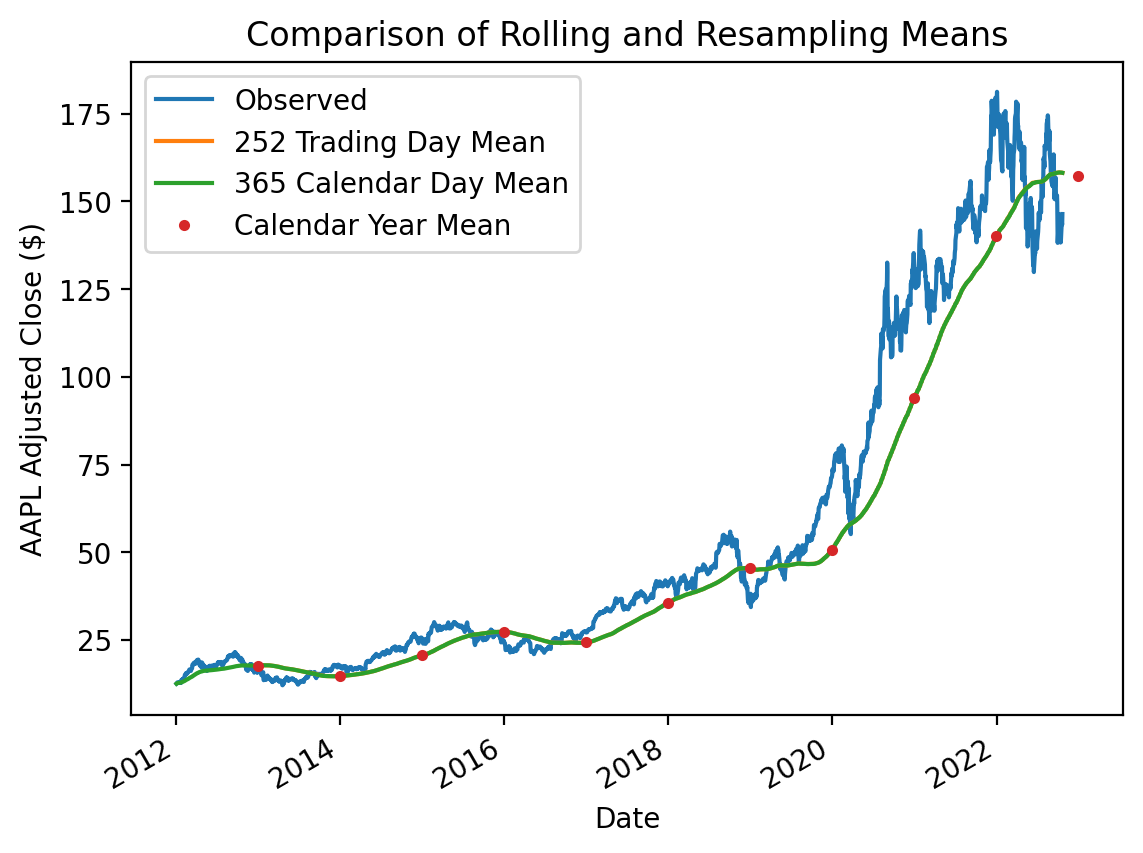

In [83]:
aapl = df.loc['2012':, ('Adj Close', 'AAPL')]
aapl.plot(label='Observed')
aapl.rolling(252).mean().plot(label='252 Trading Day Mean') # min_periods defaults to 252
aapl.rolling('365D').mean().plot(label='365 Calendar Day Mean') # min_periods defaults to 1
aapl.resample('A').mean().plot(style='.', label='Calendar Year Mean')
plt.legend()
plt.ylabel('AAPL Adjusted Close ($)')
plt.title('Comparison of Rolling and Resampling Means')
plt.show()

In [84]:
aapl_2 = df.loc['2012', ('Adj Close', 'AAPL')].to_frame('Adj Close')

In [85]:
aapl_2['N_5'] = aapl_2['Adj Close'].rolling(5).mean()
aapl_2['DO_7D'] = aapl_2['Adj Close'].rolling('7D').mean()

Two observations:

1. If we pass the window-width as an integer, the window-width is based on the number of observations and ignores time stamps
2. If we pass the window-width as an integer, the `.rolling()` method requires that number of observations for all windows (i.e., note that the moving average starts 251 trading days after the first daily price

We can use the `min_periods` argument to allow incomplete windows.
For integer window widths, `min_periods defaults` to the given integer window width.
For string date offsets, `min_periods defaults` to `1`.

### Binary Moving Window Functions

Binary moving window functions accept two inputs.
The most common example is the rolling correlation between two returns series.

In [86]:
returns = df['Adj Close'].pct_change()

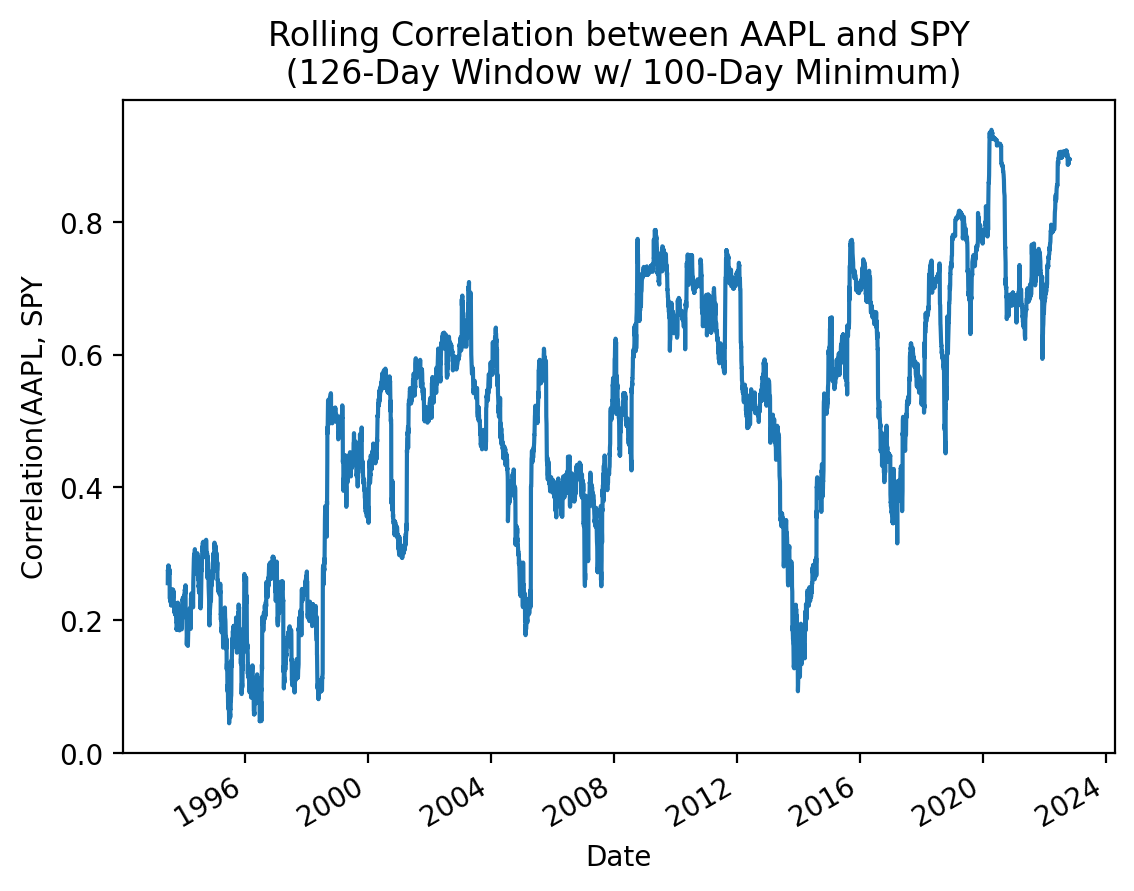

In [87]:
returns['AAPL'].rolling(126, min_periods=100).corr(returns['SPY']).plot()
plt.ylabel('Correlation(AAPL, SPY')
plt.title('Rolling Correlation between AAPL and SPY\n (126-Day Window w/ 100-Day Minimum)')
plt.show()

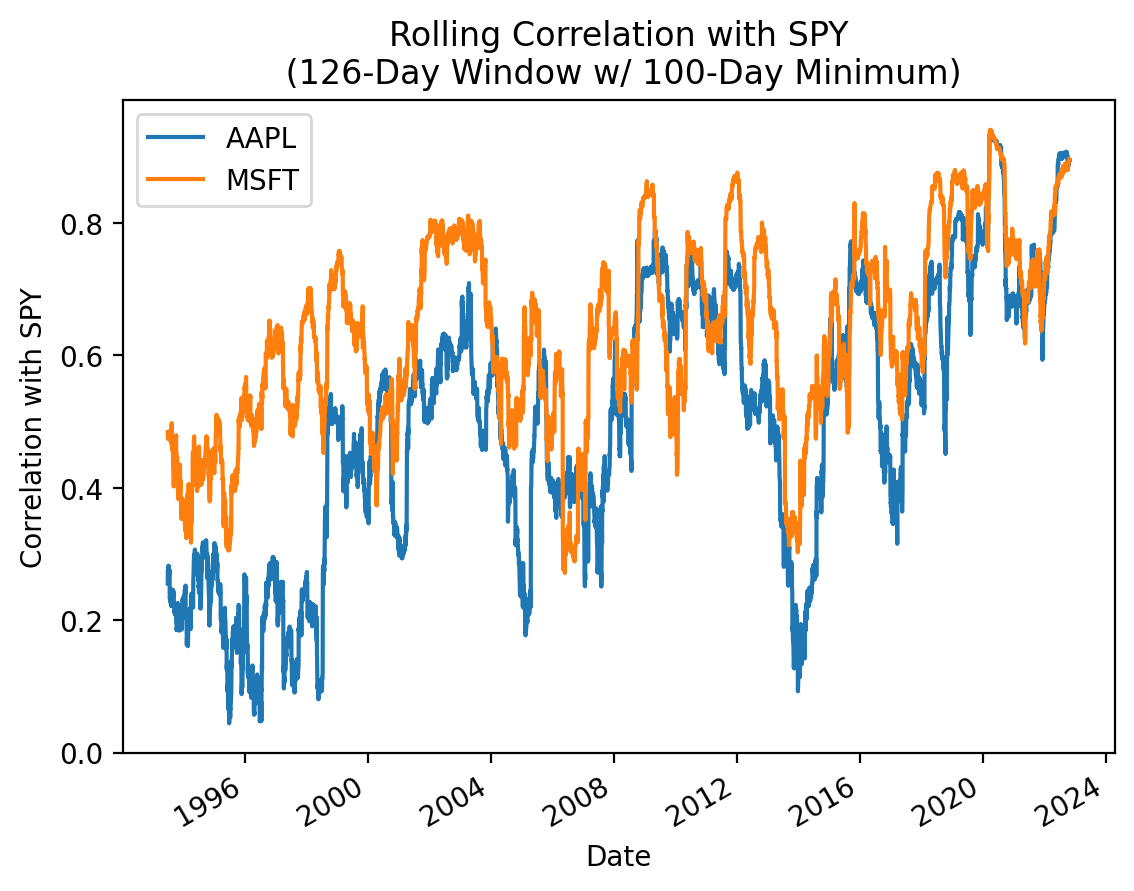

In [88]:
returns[['AAPL', 'MSFT']].rolling(126, min_periods=100).corr(returns['SPY']).plot()
plt.ylabel('Correlation with SPY')
plt.title('Rolling Correlation with SPY\n (126-Day Window w/ 100-Day Minimum)')
plt.show()

### User-Defined Moving Window Functions

Finally, we can define our own moving window functions and use the `.apply()` method to apply them
However, note that `.apply()` will be much slower than the the optimized moving window functions (e.g., `.mean()`, `.std()`, etc.).

McKinney provides an abstract example here, but we will discuss a simpler example that calculates rolling volatility.
Also, calculating rolling volatility with the `.apply()` method provides us a chance to benchmark it against the optimized version.

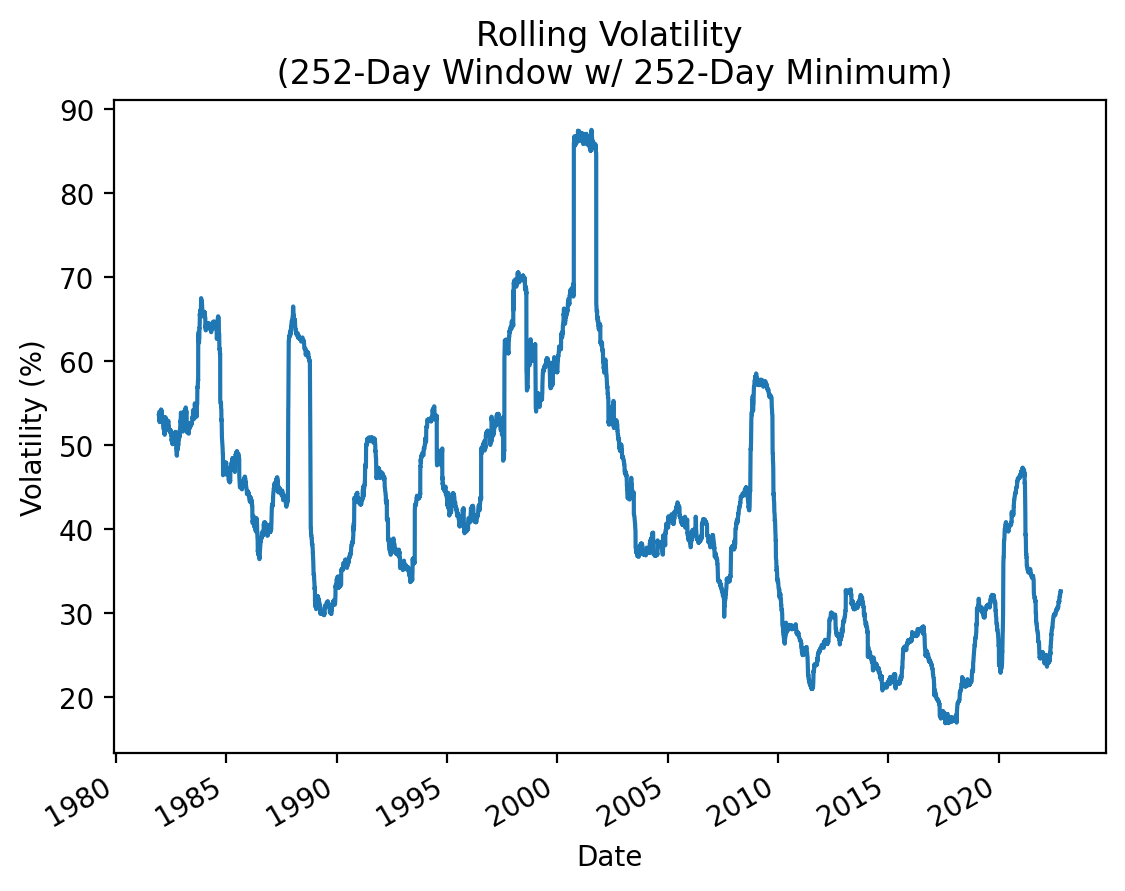

In [89]:
returns['AAPL'].rolling(252).apply(np.std).mul(np.sqrt(252) * 100).plot() # annualize and convert to percent
plt.ylabel('Volatility (%)')
plt.title('Rolling Volatility\n (252-Day Window w/ 252-Day Minimum)')
plt.show()

Do not be afraid to use `.apply()`, but realize that `.apply()` is typically 1000-times slower than the pre-built method.

In [90]:
%timeit returns['AAPL'].rolling(252).apply(np.std)

1.4 s ± 49.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [91]:
%timeit returns['AAPL'].rolling(252).std()

367 µs ± 3.66 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## Practice

***Practice:***
Keep only the first observation for each date in `dup_ts` from above.
Keep only the largest observation for each date in `dup_ts`.
Also try the `.drop_duplicates()` method

In [92]:
dup_ts.groupby(level=0).max()

2000-01-01    0
2000-01-02    3
2000-01-03    4
dtype: int32

In [93]:
dup_ts.index.drop_duplicates()

DatetimeIndex(['2000-01-01', '2000-01-02', '2000-01-03'], dtype='datetime64[ns]', freq=None)

In [94]:
df = pd.DataFrame({'a': [1, 1, 2, 2], 'b': [1, 2, 3, 4]})

In [95]:
df

,a,b
0,1,1
1,1,2
2,2,3
3,2,4


In [96]:
df.drop_duplicates(subset='a', keep='first')

,a,b
0,1,1
2,2,3


***Practice:***
Download daily data market data for TSLA and add daily returns as column named `Return`.
The add the 1 trading lag of `Return` as a column named `Return_lag1`.

In [97]:
tsla = (
    yf.download(tickers='TSLA', session=session) # download daily data for Telsa
    .assign( # add 1+ variables in a chain
        Return=lambda x: x['Adj Close'].pct_change(), # add daily returns
        Return_lag1=lambda x: x['Return'].shift() # add the one-day lag of daily returns
    )
)

[*********************100%***********************]  1 of 1 completed


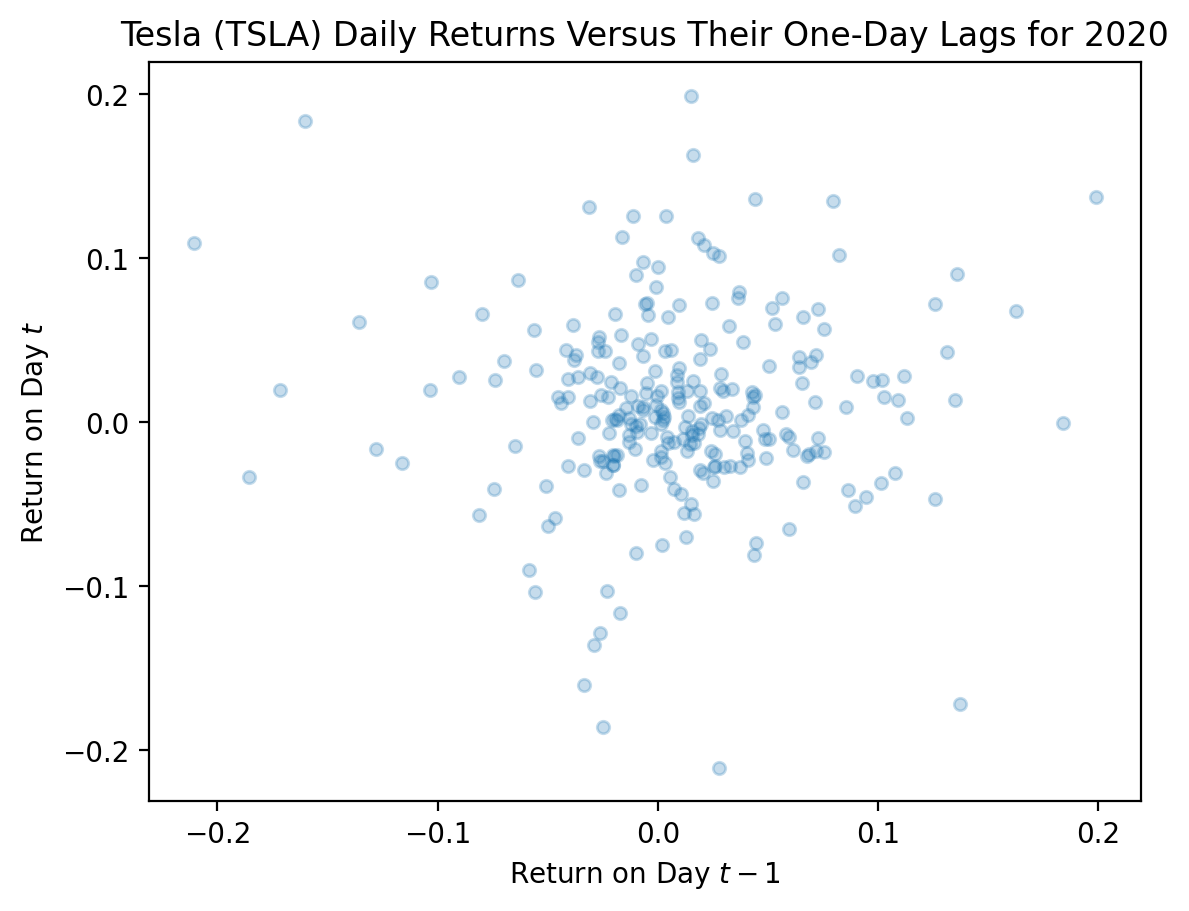

In [98]:
tsla.loc['2020'].plot(x='Return_lag1', y='Return', kind='scatter', alpha=0.25)
plt.ylabel('Return on Day $t$')
plt.xlabel('Return on Day $t-1$')
plt.title('Tesla (TSLA) Daily Returns Versus Their One-Day Lags for 2020')
plt.show()

***Practice:***
Calculate 5-minute returns for GME from 1-minute data.

_Hints:_

1. Recall that returns are the percent change of the adjust close column
2. Use the `label` and `closed` arguments so that returns are the over the _previous_ five minutes

With `interval='1m'` we can download 1-minute data from Yahoo! Finance, but we need to limit ourselves to the past 7 days of data with `period='7d'`.

In [99]:
gme = yf.download(tickers='GME', interval='1m', period='7d', session=session)

[*********************100%***********************]  1 of 1 completed


We can use the `.resample()` method with `rule='5T'` (yfinance and pandas use different abbreviations for minutes) to calculate five-minute returns by combining the `.last()` and `.pct_change()` methods.
We need to make two changes to get the behavior we get by default with daily and monthly data:

1. Set `closed='right'` and `label='right'` so that intervals include the right edge instead of the left edge and timestamped with the right edge instead of the left edge
1. Drop the overnight returns using the `.between_time()` method

We can wrap this chain with `()` so wo can insert white space, making this long chain more readable.
It might be helpful to comment and un-comment lines with `#` (the short cut is CTRL-/) to better understand what each method does.

In [100]:
(
    gme
    [['Adj Close']]
    .between_time(start_time='0930', end_time='1600')
    .resample('5T', closed='right', label='right')
    .last()
    .pct_change()
)

,Adj Close
Datetime,
2022-10-13 09:30:00-04:00,NaN
2022-10-13 09:35:00-04:00,-0.0069
2022-10-13 09:40:00-04:00,-0.0170
2022-10-13 09:45:00-04:00,0.0031
2022-10-13 09:50:00-04:00,0.0215
...,...
2022-10-21 13:50:00-04:00,-0.0012
2022-10-21 13:55:00-04:00,0.0044
2022-10-21 14:00:00-04:00,0.0000


***Practice:***
Calculate rolling capital asset pricing model (CAPM) betas for these stocks.
The CAPM says the risk premium on a stock depends on the risk-free rate, beta, and the risk premium on the market:
$$E(R_{stock}) = R_f + \beta_{stock} \times (E(R_{market}) - R_f).$$
We can calculate CAPM betas as:
$$\beta_{stock} = \frac{Cov(R_{stock} - R_f, R_{market} - R_f)}{Var(R_{market} - R_f)}.$$

In [101]:
ff = pdr.get_data_famafrench('F-F_Research_Data_Factors_daily', start='1900', session=session)[0] / 100

We should use *excess* returns (i.e., returns relative to the risk-free rate or $R_{stock} - R_f$) to estimate betas.
We can easily calculate *excess* returns for all columns with the `.sub()` method.

In [102]:
excess_returns = returns.sub(ff['RF'], axis=0).dropna()

We can calculate the numerator and denominator separately, then divide.

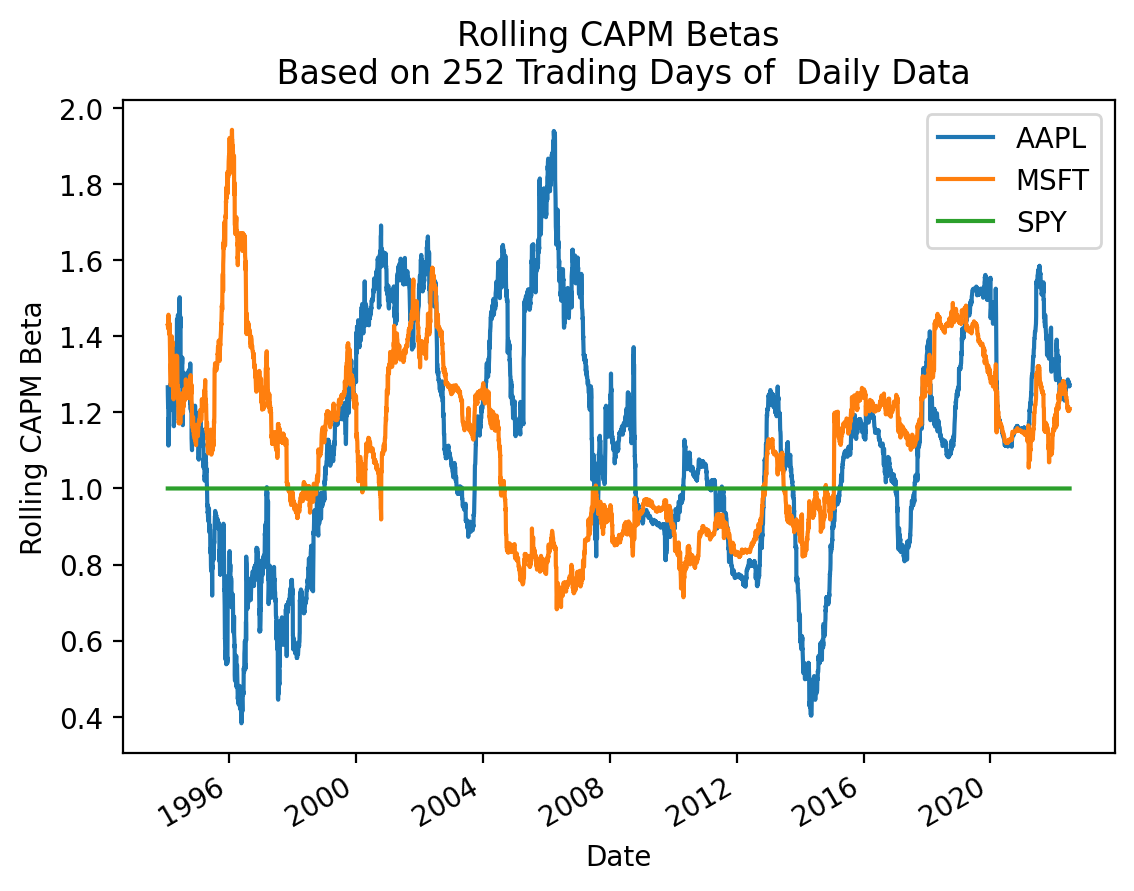

In [103]:
cov_term = excess_returns.rolling(252).cov(excess_returns['SPY'])
var_term = excess_returns['SPY'].rolling(252).var()
cov_term.div(var_term, axis=0).plot()
plt.ylabel('Rolling CAPM Beta')
plt.title('Rolling CAPM Betas\n Based on 252 Trading Days of  Daily Data')
plt.show()

***For Friday:*** try to use the `.apply()` method to collapse the beta calculation above into one-line of code.

In [106]:
def beta(x, mkt=excess_returns['SPY']):
    return x.cov(mkt) / mkt.loc[x.index].var()

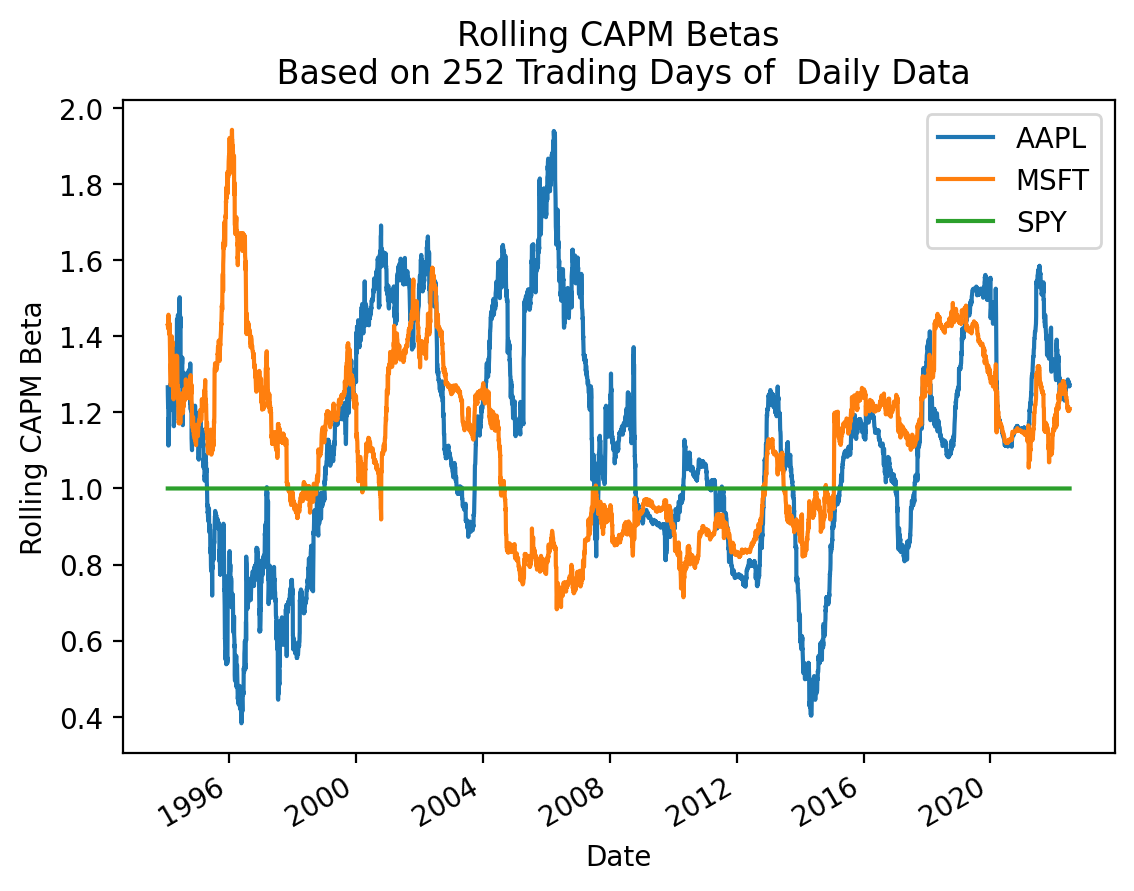

In [118]:
excess_returns.rolling(252).apply(beta).plot()
plt.ylabel('Rolling CAPM Beta')
plt.title('Rolling CAPM Betas\n Based on 252 Trading Days of  Daily Data')
plt.show()

***Practice:***
The Sharpe Ratio is often used to evaluate fund managers.
The Sharpe Ratio is $$SR_i = \frac{\overline{R_i - R_f}}{\sigma},$$ where $\overline{R_i-R_f}$ is mean fund return relative to the risk-free rate over some period and $\sigma$ is the standard deviation of $R_i-R_f$ over the same period.
While the Sharpe Ratio is typically used for funds, we can apply it to a single stock to test our knowledge of the `.rolling()` method.
Calculate and plot the one-year rolling Sharpe Ratio for GME using all available daily data.
Download GME data from Yahoo! Finance and risk-free rate data from Ken French.

In [109]:
def sharpe_ratio(x, rf=ff['RF']):
    x_rf = x - rf
    return np.sqrt(252) * x_rf.mean() / x_rf.std()

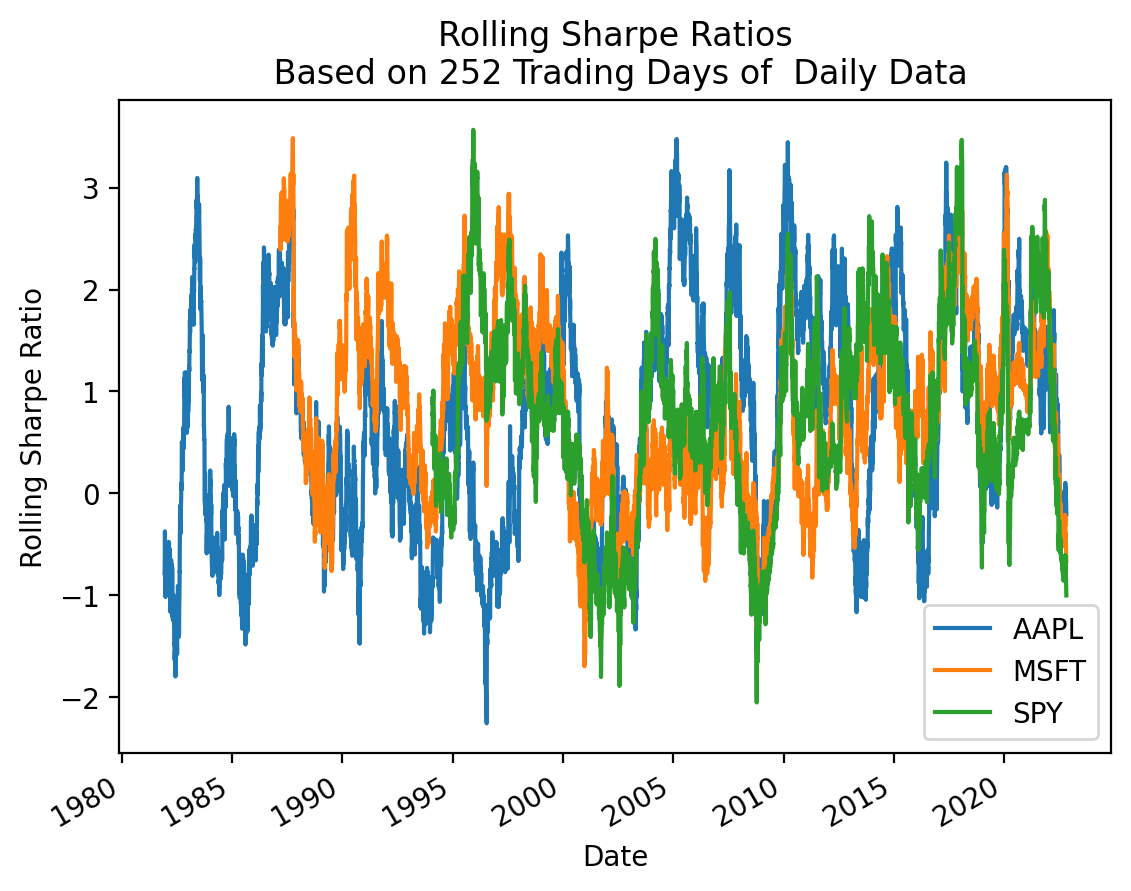

In [119]:
returns.rolling(252).apply(sharpe_ratio).plot()
plt.ylabel('Rolling Sharpe Ratio')
plt.title('Rolling Sharpe Ratios\n Based on 252 Trading Days of  Daily Data')
plt.show()

In [116]:
gme = yf.download('GME', session=session)['Adj Close'].pct_change()
if gme.index.tz is not None:
    gme.index = gme.index.tz_localize(None)

[*********************100%***********************]  1 of 1 completed


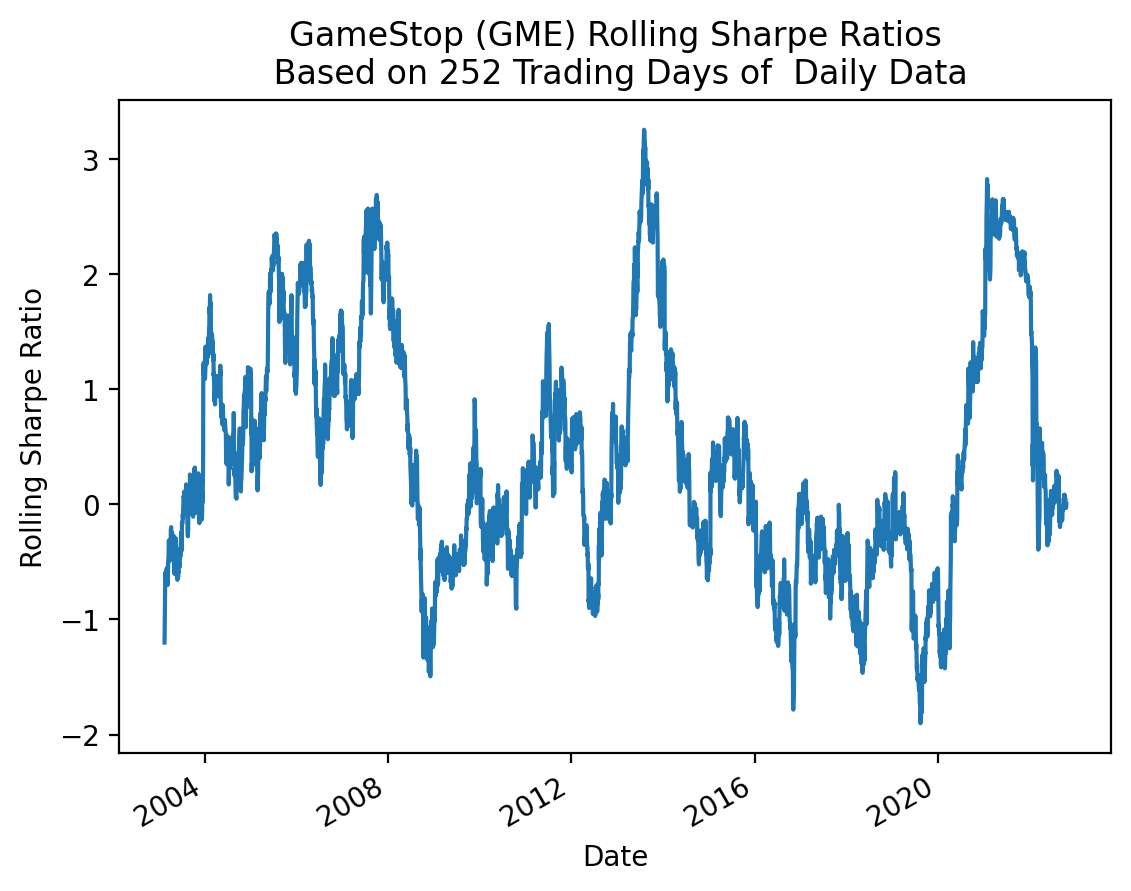

In [120]:
gme.rolling(252).apply(sharpe_ratio).plot()
plt.ylabel('Rolling Sharpe Ratio')
plt.title('GameStop (GME) Rolling Sharpe Ratios\n Based on 252 Trading Days of  Daily Data')
plt.show()